# Combining graphs from multiple data sources
In this notebook you will be able to search for protein interactions (Uniprot), expressions in tissues (Bgee). Finally you will lear how to assemble a new graph of co-expressed gene.  

In [1]:
!pip install rdflib
!pip install sparqlwrapper

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
  Using cached SPARQLWrapper-2.0.0-py3-none-any.whl (28 kB)
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [2]:
import rdflib
from SPARQLWrapper import SPARQLWrapper, JSON, TURTLE

## 1. Find interacting proteins with SCN5A (from Uniprot)

By browsing http://uniprot.org, find the web page describing SCN5A_HUMAN. 

## 2. Look at the RDF graph describing SCN5A 

You can directly access RDF https://www.uniprot.org/uniprotkb/Q14524.ttl . 

By using the following graph pattern write a SPARQL query to find the proteins interacting with SCN5A. 

<https://www.uniprot.org/uniprotkb/Q14524.ttl>

Find all PPI in which Q14524 is a participant.
You can use the following graph pattern : 
```
VALUES ?P1 {uniprot:Q14524}
?interaction up:participant ?P1 . 
?interaction up:participant ?P2 .
?P1 up:mnemonic ?P1_label .
?P2 up:mnemonic ?P2_label .
FILTER (?P2 != ?P1)
```


In [12]:
uniprot_query = """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs:<http://www.w3.org/2000/01/rdf-schema#>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX dc: <http://purl.org/dc/elements/1.1/>
PREFIX dcterms: <http://purl.org/dc/terms/>

PREFIX taxon: <http://purl.uniprot.org/taxonomy/>
PREFIX uniprot: <http://purl.uniprot.org/uniprot/>
PREFIX up:<http://purl.uniprot.org/core/>

SELECT * WHERE {

    VALUES ?P1 {uniprot:Q14524}
    ?P1 up:mnemonic ?P1_label .
    ?P1 up:organism ?org . 
    ?P1 up:interaction ?interaction . 
    ?P2 up:interaction ?interaction .
    ?P2 up:mnemonic ?P2_label .
    ?interaction up:experiments ?nb_exp .

} limit 10

"""

sparql = SPARQLWrapper("http://sparql.uniprot.org/sparql/")
sparql.setQuery(uniprot_query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()
print(results['results']['bindings'])

list_of_genes = ["SCN5A"]
for r in results['results']['bindings']:
    #print(f"{r['P1_label']['value']} <-> {r['P2_label']['value']} in {r['nb_expe']['value']} experiments.")
    #list_of_genes.append(r['P2_label']['value'].split("_HUMAN")[0])
    print(f"{r}")

list_of_genes

[{'P1': {'type': 'uri', 'value': 'http://purl.uniprot.org/uniprot/Q14524'}, 'P2': {'type': 'uri', 'value': 'http://purl.uniprot.org/uniprot/Q14524'}, 'nb_exp': {'datatype': 'http://www.w3.org/2001/XMLSchema#int', 'type': 'literal', 'value': '3'}, 'org': {'type': 'uri', 'value': 'http://purl.uniprot.org/taxonomy/9606'}, 'P2_label': {'type': 'literal', 'value': 'SCN5A_HUMAN'}, 'interaction': {'type': 'uri', 'value': 'http://purl.uniprot.org/intact/11524452-14276801'}, 'P1_label': {'type': 'literal', 'value': 'SCN5A_HUMAN'}}, {'P1': {'type': 'uri', 'value': 'http://purl.uniprot.org/uniprot/Q14524'}, 'P2': {'type': 'uri', 'value': 'http://purl.uniprot.org/uniprot/Q8N9N5'}, 'nb_exp': {'datatype': 'http://www.w3.org/2001/XMLSchema#int', 'type': 'literal', 'value': '3'}, 'org': {'type': 'uri', 'value': 'http://purl.uniprot.org/taxonomy/9606'}, 'P2_label': {'type': 'literal', 'value': 'BANP_HUMAN'}, 'interaction': {'type': 'uri', 'value': 'http://purl.uniprot.org/intact/11524452-14276801'}, 'P

['SCN5A']

In [24]:
!pip install networkx
!pip install matplotlib
!pip install scipy

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


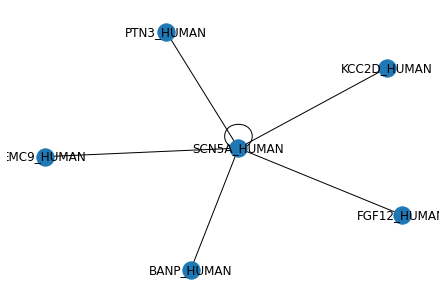

In [33]:
import networkx as nx
from matplotlib import pyplot as plt

g = nx.Graph()

for r in results['results']['bindings']:
    g.add_edge(r['P1_label']['value'], r['P2_label']['value'], nbExperiments = r['nb_exp']['value'])
    
nx.draw(g, with_labels=True)
plt.show()


## 3. Post process your results get a list of gene identifiers (remove the "_HUMAN" postfix)

you should get something like `['SCN5A', 'KCC2D', 'FGF12', 'ZMY19', 'EMC9', 'BANP', 'Q49AR9', 'TEKT4', 'PTN3']`

In [7]:
genes = '\"'+"\" \"".join(list_of_genes)+'\"'
genes

'"SCN5A"'

## 4. Filter tissues in which genes are expressed (from Bgee)

### 4.1. Find tissues in which SCN5A is expressed 

Bgee is a gene expression RDF dataset which integrates GTex.  

Based on the following graph patterns, assemble a SPARQL query to retrieve tissues in which TEKT4 is expressed, for HUMANS (http://purl.uniprot.org/taxonomy/9606). 

*Anatomical entities*
```
?anatEntity a genex:AnatomicalEntity ;
                rdfs:label ?anatName .
```

*Case insensitive matching of a string value*
```
FILTER (?geneName = 'TEKT4')
```

*Human organisms*
```
?organism obo:RO_0002162 <http://purl.uniprot.org/taxonomy/9606> . 
```

*Some genes from some organisms*
```
?seq a orth:Gene;
     orth:organism ?organism ;
     rdfs:label ?geneName .
```

*Some genes expressed in some tissues*
```
?seq genex:isExpressedIn ?anatEntity.
```


In [22]:
bgee_query = """
PREFIX orth: <http://purl.org/net/orth#>
PREFIX genex: <http://purl.org/genex#>
PREFIX obo: <http://purl.obolibrary.org/obo/>

SELECT DISTINCT ?anatEntity ?anatName WHERE {
    ?anatEntity a genex:AnatomicalEntity ;
                rdfs:label ?anatName .
    ?organism obo:RO_0002162 <http://purl.uniprot.org/taxonomy/9606> . 
    ?seq a orth:Gene;
     orth:organism ?organism ;
     rdfs:label ?geneName .
    ?seq genex:isExpressedIn ?anatEntity.
    FILTER (?geneName = 'TEKT4')
    
}
"""

sparql = SPARQLWrapper("http://bgee.org/sparql")
sparql.setQuery(bgee_query)
sparql.setReturnFormat(JSON)
res = sparql.query().convert()
#print(res["results"]["bindings"])
for r in res["results"]["bindings"]:
    print(f"{r['anatEntity']['value']}: {r['anatName']['value']}")

http://purl.obolibrary.org/obo/UBERON_0000007: pituitary gland
http://purl.obolibrary.org/obo/UBERON_0001898: hypothalamus
http://purl.obolibrary.org/obo/UBERON_0002046: thyroid gland
http://purl.obolibrary.org/obo/UBERON_0002369: adrenal gland
http://purl.obolibrary.org/obo/UBERON_0003296: gland of diencephalon
http://purl.obolibrary.org/obo/UBERON_0000029: lymph node
http://purl.obolibrary.org/obo/UBERON_0001871: temporal lobe
http://purl.obolibrary.org/obo/UBERON_0002465: lymphoid system
http://purl.obolibrary.org/obo/UBERON_0001514: descending aorta
http://purl.obolibrary.org/obo/UBERON_0002345: descending thoracic aorta
http://purl.obolibrary.org/obo/UBERON_0003516: hindlimb blood vessel
http://purl.obolibrary.org/obo/UBERON_0007304: appendage vasculature
http://purl.obolibrary.org/obo/UBERON_0001516: abdominal aorta
http://purl.obolibrary.org/obo/CL_0000000: cell
http://purl.obolibrary.org/obo/UBERON_0000014: zone of skin
http://purl.obolibrary.org/obo/UBERON_0000020: sense organ

## 4.2. Build a subgraph with a CONSTRUCT ... WHERE query 
A "CONSTRUCT" query builds a sub-graph from a graph pattern matched in the where clause. 

Structure of a "CONSTRUCT" query: 
```
CONSTRUCT {
... sub graph pattern ...
} WHERE {
... graph pattern ...
}
```

Reuse the "WHERE" clause of the previous query to build a subgraph with only `genex:isExpressedIn` and `rdfs:label` relations. 

In [40]:
bgee_subgraph = """
PREFIX orth: <http://purl.org/net/orth#>
PREFIX genex: <http://purl.org/genex#>
PREFIX obo: <http://purl.obolibrary.org/obo/>
PREFIX etbii: <http://etbii/>

CONSTRUCT {
   ?seq etbii:isTissu ?anatName .

} WHERE {
    ?anatEntity a genex:AnatomicalEntity ;
                rdfs:label ?anatName .
    ?organism obo:RO_0002162 <http://purl.uniprot.org/taxonomy/9606> . 
    ?seq a orth:Gene;
     orth:organism ?organism ;
     rdfs:label ?geneName .
    ?seq genex:isExpressedIn ?anatEntity.
    FILTER (?geneName = 'TEKT4')
}
"""
sparql = SPARQLWrapper("http://bgee.org/sparql")
sparql.setQuery(bgee_subgraph)
results = sparql.query().convert()
print(len(results))
#print(results)
print(results.serialize(format="turtle"))

KG = results

301
@prefix ns2: <http://etbii/> .

<http://omabrowser.org/ontology/oma#GENE_ENSG00000163060> ns2:isTissu "Ammon's horn",
        "Brodmann (1909) area 9",
        "C1 segment of cervical spinal cord",
        "Peyer's patch",
        "abdomen",
        "abdominal aorta",
        "abdominal segment of trunk",
        "abdominal wall",
        "adenohypophysis",
        "adipose tissue",
        "adipose tissue of abdominal region",
        "adrenal cortex",
        "adrenal gland",
        "adult mammalian kidney",
        "alimentary part of gastrointestinal system",
        "amygdala",
        "anatomical entity",
        "anatomical structure",
        "anatomical system",
        "anterior cingulate cortex",
        "aorta",
        "apex of heart",
        "appendage musculature",
        "appendage vasculature",
        "arterial blood vessel",
        "arterial system",
        "artery",
        "ascending aorta",
        "basal forebrain",
        "blood",
        "blood cell",

Now you can use a VALUES clause to inject the results of the previous query `VALUES ?x { v1 v2 v3 ... vN }` in this new query. 

Modify the query to inject `"SCN5A" "KCC2D" "FGF12" "ZMY19" "EMC9" "BANP" "Q49AR9" "TEKT4" "PTN3"` as gene of interest.  

In [42]:
bgee_subgraph = """
PREFIX orth: <http://purl.org/net/orth#>
PREFIX genex: <http://purl.org/genex#>
PREFIX obo: <http://purl.obolibrary.org/obo/>

CONSTRUCT {
   ?seq genex:isExpressedIn ?anatEntity ;
   rdfs:label ?geneName .

} WHERE {
    VALUE(?g_label {"""+genes+"""}) .

    ?anatEntity a genex:AnatomicalEntity ;
                rdfs:label ?anatName .
    ?organism obo:RO_0002162 <http://purl.uniprot.org/taxonomy/9606> . 
    ?seq a orth:Gene;
     orth:organism ?organism ;
     rdfs:label ?geneName .
    ?seq genex:isExpressedIn ?anatEntity.
    FILTER (regex(?anatEntity, "CL_"))
}
"""
sparql = SPARQLWrapper("http://bgee.org/sparql")
sparql.setQuery(bgee_subgraph)
results = sparql.query().convert()
print(len(results))
#print(results)
print(results.serialize(format="turtle"))

QueryBadFormed: QueryBadFormed: A bad request has been sent to the endpoint: probably the SPARQL query is badly formed. 

Response:
b'Virtuoso 37000 Error SP030: SPARQL compiler, line 13: syntax error at \'VALUE\' before \'(\'\n\nSPARQL query:\ndefine sql:big-data-const 0 \n#output-format:application/sparql-results+xml\n\nPREFIX orth: <http://purl.org/net/orth#>\nPREFIX genex: <http://purl.org/genex#>\nPREFIX obo: <http://purl.obolibrary.org/obo/>\n\nCONSTRUCT {\n   ?seq genex:isExpressedIn ?anatEntity ;\n   rdfs:label ?geneName .\n\n} WHERE {\n    VALUE(?g_label {"SCN5A"}) .\n    ?anatEntity a genex:AnatomicalEntity ;\n                rdfs:label ?anatName .\n    ?organism obo:RO_0002162 <http://purl.uniprot.org/taxonomy/9606> . \n    ?seq a orth:Gene;\n     orth:organism ?organism ;\n     rdfs:label ?geneName .\n    ?seq genex:isExpressedIn ?anatEntity.\n    FILTER (regex(?anatEntity, "CL_"))\n}\n'

## 5  Build a network of genes that are co-expressed in the same tissue

The result of a "CONSTRUCT" is a graph object. You can now write and execute a CONSTRUCT query on this graph to create new `coExpressedWith` between genes. 

In [43]:
q2 = """
PREFIX genex: <http://purl.org/genex#>
PREFIX etbii:<http://etbii.fr/ontology/>

CONSTRUCT {
    
    ?gene1 etbii:coExpressedWith ?gene2 .
    
} WHERE {
    gene1 genex:isExpressedIN ?tissue .
    gene2 genex:isExpressedIN ?tissue .
    FILTER(gene1 != gene2)
    
}
"""

coExNet = KG.query(q2)
print(coExNet.serialize(format="turtle").decode())

ParseException: Expected {SelectQuery | ConstructQuery | DescribeQuery | AskQuery}, found 'gene1'  (at char 160), (line:10, col:5)